In [33]:
# Bibliotecas
import pandas as pd
import numpy as np
import glob

In [34]:
# Listar os arquivos CSV na pasta 'uploads'
arquivo_csv = glob.glob('uploads/processos_*.csv')
# Carregar os arquivos CSV e concatenar em um único DataFrame
dfs = []
for arquivo in arquivo_csv:  # lista/iterável com os caminhos tipo 'processos_1.csv', 'processos_2.csv', ...
    df_ano = pd.read_csv(arquivo, sep=',', encoding='utf-8')
    dfs.append(df_ano)

df = pd.concat(dfs, ignore_index=True)

print(df.shape)

C:\Users\jcpsrodrigues\AppData\Local\Temp\ipykernel_7500\1372791997.py:6: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  df_ano = pd.read_csv(arquivo, sep=',', encoding='utf-8')


(7267054, 10)


In [35]:
# Limpeza e tratamento
# Verificar o nome correto das colunas (pode haver diferenças de acentuação ou espaços)
colunas = df.columns.tolist()

# Encontrar as colunas de data corretamente
coluna_serventia = [col for col in colunas if 'serventia' in col.lower()][0]
coluna_distribuicao = [col for col in colunas if 'data_distribuicao' in col.lower()][0]
coluna_baixa = [col for col in colunas if 'data_baixa' in col.lower()][0]
coluna_area_acao = [col for col in colunas if 'nome_area_acao' in col.lower()][0]
coluna_processo_id = [col for col in colunas if 'numero' in col.lower()][0]
coluna_comarca = [col for col in colunas if 'comarca' in col.lower()][0]

# Renomear colunas para garantir consistência
df = df.rename(columns={
coluna_distribuicao: 'data_distribuicao',
coluna_baixa: 'data_baixa',
coluna_area_acao: 'nome_area_acao',
coluna_processo_id: 'numero',
coluna_comarca: 'comarca',
coluna_serventia: 'serventia'
})

# Converter colunas de data para datetime com tratamento de erros
df['data_distribuicao'] = pd.to_datetime(df['data_distribuicao'], errors='coerce')
df['data_baixa'] = pd.to_datetime(df['data_baixa'], errors='coerce')

# CRIAÇÃO DOS TABELÕES DE ESTATÍSTICAS (ANUAL E MENSAL) >> Comarca e Serventia >> Will

In [39]:
# --- 1. PREPARAÇÃO DOS DADOS ---
# Extração de componentes de data
print("Extraindo datas...")
df['ano_distribuicao'] = df['data_distribuicao'].dt.year
df['mes_distribuicao'] = df['data_distribuicao'].dt.month
df['dia_distribuicao'] = df['data_distribuicao'].dt.day

df['ano_baixa'] = df['data_baixa'].dt.year
df['mes_baixa'] = df['data_baixa'].dt.month
df['dia_baixa'] = df['data_baixa'].dt.day

# Chaves de agrupamento
grouping_keys = ['comarca', 'serventia']

# ==============================================================================
# FUNÇÃO GENÉRICA DE CÁLCULO (Para evitar repetição de código)
# ==============================================================================
def calcular_estatisticas_cohort(df_main, cols_dist, cols_baixa, nome_periodo):
    """
    Calcula Distribuídos, Baixados e Pendentes.
    REVISÃO DOS CÁLCULOS:
      - Distribuídos: contagem por data_distribuicao (entrada)
      - Baixados: contagem por data_baixa (referência), dentro do par entrada->referência
      - Pendentes: contagem de data_baixa nula/vazia (NaT), agrupada por entrada
    """
    
    # 1. Calcular TOTAL DE DISTRIBUÍDOS
    cols_group_dist = cols_dist + grouping_keys
    df_dist = df_main.groupby(cols_group_dist).size().reset_index(name=f'Distribuídos{nome_periodo}')
    
    # 2. Calcular TOTAL DE BAIXADOS (somente registros com baixa)
    cols_group_baixa = cols_dist + cols_baixa + grouping_keys
    df_baixa = df_main.dropna(subset=cols_baixa).groupby(cols_group_baixa).size().reset_index(name=f'Baixados{nome_periodo}')
    
    # 3. Calcular TOTAL DE PENDENTES (data_baixa nula/vazia -> componentes de baixa NaN)
    df_pend = df_main[df_main[cols_baixa[0]].isna()].groupby(cols_group_dist).size().reset_index(name=f'Pendentes{nome_periodo}')
    
    # 4. CRIAÇÃO DO GRID (Cross Join)
    unique_dist = df_dist[cols_dist].drop_duplicates()
    unique_baixa = df_main[cols_baixa].dropna().drop_duplicates()
    unique_units = df_main[grouping_keys].drop_duplicates()
    
    # Cross Join 1: Datas de Dist x Datas de Baixa (usando merge dummy para performance)
    df_dates = pd.merge(
        unique_dist.assign(key=1), 
        unique_baixa.assign(key=1), 
        on='key'
    ).drop('key', axis=1)
    
    # --- FILTRO DE DATAS ---
    if len(cols_dist) == 1: # Anual
        df_dates = df_dates[df_dates[cols_baixa[0]] >= df_dates[cols_dist[0]]]
        
    elif len(cols_dist) == 2: # Mensal
        ano_d = df_dates[cols_dist[0]].astype(int).astype(str)
        mes_d = df_dates[cols_dist[1]].astype(int).astype(str)
        
        ano_b = df_dates[cols_baixa[0]].astype(int).astype(str)
        mes_b = df_dates[cols_baixa[1]].astype(int).astype(str)
        
        d_dist = pd.to_datetime(ano_d + '-' + mes_d + '-01')
        d_baixa = pd.to_datetime(ano_b + '-' + mes_b + '-01')
        
        df_dates = df_dates[d_baixa >= d_dist]

    # Cross Join 2: (Datas) x (Comarca/Serventia)
    df_grid = pd.merge(
        df_dates.assign(key=1),
        unique_units.assign(key=1),
        on='key'
    ).drop('key', axis=1)
    
    # 5. MERGES (Juntar dados reais no Grid)
    df_final = pd.merge(df_grid, df_dist, on=cols_dist + grouping_keys, how='left')
    df_final = pd.merge(df_final, df_baixa, on=cols_dist + cols_baixa + grouping_keys, how='left')
    df_final = pd.merge(df_final, df_pend, on=cols_dist + grouping_keys, how='left')
    
    # Preencher Zeros
    df_final[f'Distribuídos{nome_periodo}'] = df_final[f'Distribuídos{nome_periodo}'].fillna(0).astype(int)
    df_final[f'Baixados{nome_periodo}'] = df_final[f'Baixados{nome_periodo}'].fillna(0).astype(int)
    df_final[f'Pendentes{nome_periodo}'] = df_final[f'Pendentes{nome_periodo}'].fillna(0).astype(int)
    
    # Filtrar apenas onde houve distribuição
    df_final = df_final[df_final[f'Distribuídos{nome_periodo}'] > 0].copy()
    
    # 6. TAXA DE CONGESTIONAMENTO (com a definição solicitada)
    soma = df_final[f'Baixados{nome_periodo}'] + df_final[f'Pendentes{nome_periodo}']
    df_final[f'Taxa de Congestionamento{nome_periodo} (%)'] = np.where(
        soma > 0, (df_final[f'Pendentes{nome_periodo}'] / soma) * 100, 0
    ).round(2)

    # 7. CONVERSÃO FINAL PARA INTEIRO (NOVO BLOCO)
    cols_tempo = cols_dist + cols_baixa
    for col in cols_tempo:
        if col in df_final.columns:
            df_final[col] = df_final[col].astype(int)

    return df_final

# ==============================================================================
# 2. CÁLCULOS ANUAIS
# ==============================================================================
print("Calculando estatísticas anuais...")
estatisticas_anuais = calcular_estatisticas_cohort(
    df, 
    cols_dist=['ano_distribuicao'], 
    cols_baixa=['ano_baixa'], 
    nome_periodo=''
)

# Ajustes finais de colunas e ordenação
estatisticas_anuais = estatisticas_anuais.rename(columns={'ano_distribuicao': 'ano'})
cols_order = ['ano', 'ano_baixa', 'comarca', 'serventia', 'Distribuídos', 'Baixados', 'Pendentes', 'Taxa de Congestionamento (%)']
estatisticas_anuais = estatisticas_anuais[cols_order].sort_values(
    by=['ano', 'ano_baixa', 'comarca', 'serventia'], 
    ascending=[False, False, True, True]
)

# ==============================================================================
# 3. CÁLCULOS MENSAIS
# ==============================================================================
print("Calculando estatísticas mensais...")
estatisticas_mes = calcular_estatisticas_cohort(
    df, 
    cols_dist=['ano_distribuicao', 'mes_distribuicao'], 
    cols_baixa=['ano_baixa', 'mes_baixa'], 
    nome_periodo='_mes'
)

# Ajustes finais de colunas e ordenação
estatisticas_mes = estatisticas_mes.rename(columns={'ano_distribuicao': 'ano', 'mes_distribuicao': 'mes'})
cols_order_mes = ['ano', 'mes', 'ano_baixa', 'mes_baixa', 'comarca', 'serventia', 
                  'Distribuídos_mes', 'Baixados_mes', 'Pendentes_mes', 'Taxa de Congestionamento_mes (%)']

estatisticas_mes = estatisticas_mes[cols_order_mes].sort_values(
    by=['ano', 'mes', 'ano_baixa', 'mes_baixa', 'comarca', 'serventia'],
    ascending=[False, False, False, False, True, True]
)

estatisticas_mes = estatisticas_mes.rename(columns={
    'ano_baixa': 'ano_baixa', 
    'mes_baixa': 'mes_baixa',
    'ano': 'ano_distribuicao',
    'mes': 'mes_distribuicao'   
})

estatisticas_anuais = estatisticas_anuais.rename(columns={
    'ano_baixa': 'ano_baixa', 
    'ano': 'ano_distribuicao'
})

print("Concluído!")

Extraindo datas...
Calculando estatísticas anuais...
Calculando estatísticas mensais...
Concluído!


# Validações

In [40]:
estatisticas_anuais.sample(50)

,ano_distribuicao,ano_baixa,comarca,serventia,Distribuídos,Baixados,Pendentes,Taxa de Congestionamento (%)
2075160,2015,2023,HIDROLÂNDIA,Hidrolândia - Juizado Especial Criminal,358,2,0,0.00
1979804,2010,2011,ITUMBIARA,Itumbiara - 2ª Vara Cível e Ambiental,63,0,0,0.00
2056647,2013,2022,SANTA CRUZ DE GOIÁS,Santa Cruz de Goiás - Vara Criminal,3,3,0,0.00
2062540,2014,2015,PADRE BERNARDO,Padre Bernardo - Vara de Família e Sucessões,36,0,1,100.00
2045862,2013,2015,JANDAIA,Jandaia - Vara Cível,42,0,0,0.00
2067101,2014,2018,SANTO ANTÔNIO DO DESCOBERTO,Santo Antônio do Descoberto - Juizado Especial...,665,11,0,0.00
1697326,1997,2024,FAZENDA NOVA,Fazenda Nova - Juizado Especial Cível,1,0,0,0.00
2059947,2014,2023,RIALMA,Rialma - Vara Cível,39,4,13,76.47
1970030,2009,2020,GOIANÉSIA,Goianésia - Vara de Família e Sucessões - I,9,1,0,0.00
1972396,2009,2021,ITAJÁ,Itajá - Vara da Infância e Juventude Cível,1,0,0,0.00


In [41]:
estatisticas_mes.head(50)

,ano_distribuicao,mes_distribuicao,ano_baixa,mes_baixa,comarca,serventia,Distribuídos_mes,Baixados_mes,Pendentes_mes,Taxa de Congestionamento_mes (%)
162111364,2024,12,2024,12,ABADIÂNIA,Abadiânia - Juizado Especial Criminal,5,0,5,100.00
162111235,2024,12,2024,12,ABADIÂNIA,Abadiânia - Juizado Especial Cível,11,1,10,90.91
162111826,2024,12,2024,12,ABADIÂNIA,Abadiânia - Juizado das Fazendas Públicas,2,0,2,100.00
162111669,2024,12,2024,12,ABADIÂNIA,Abadiânia - Vara Criminal,3,1,2,66.67
162111666,2024,12,2024,12,ABADIÂNIA,Abadiânia - Vara Cível,17,0,17,100.00
162111186,2024,12,2024,12,ABADIÂNIA,Abadiânia - Vara das Fazendas Públicas,5,0,5,100.00
162111182,2024,12,2024,12,ABADIÂNIA,Abadiânia - Vara de Família e Sucessões,4,0,4,100.00
162111213,2024,12,2024,12,ACREÚNA,Acreúna - Juizado Especial Criminal,3,0,3,100.00
162111248,2024,12,2024,12,ACREÚNA,Acreúna - Juizado Especial Cível,5,0,5,100.00
162112096,2024,12,2024,12,ACREÚNA,Acreúna - Juizado das Fazendas Públicas,1,0,1,100.00


# Gerador de Arquivos:

In [ ]:
# Gera o arquivo JSON com o dataframe completo por mês (Comarca e Serventia): 
output_filename_json_mes = 'datasets/tx_cong_mes.json'
estatisticas_mes.to_json(output_filename_json_mes, orient='records', indent=4, force_ascii=False)

In [ ]:
# Gera o arquivo JSON com o dataframe completo por ano (Comarca e Serventia): 
output_filename_json_ano = 'datasets/tx_cong_ano.json'
estatisticas_anuais.to_json(output_filename_json_ano, orient='records', indent=4, force_ascii=False)

# Gráfico e Validação dos Dados

C:\Users\jcpsrodrigues\AppData\Local\Temp\ipykernel_7500\2198421969.py:12: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  df_ano = pd.read_csv(arquivo, sep=',', encoding='utf-8')


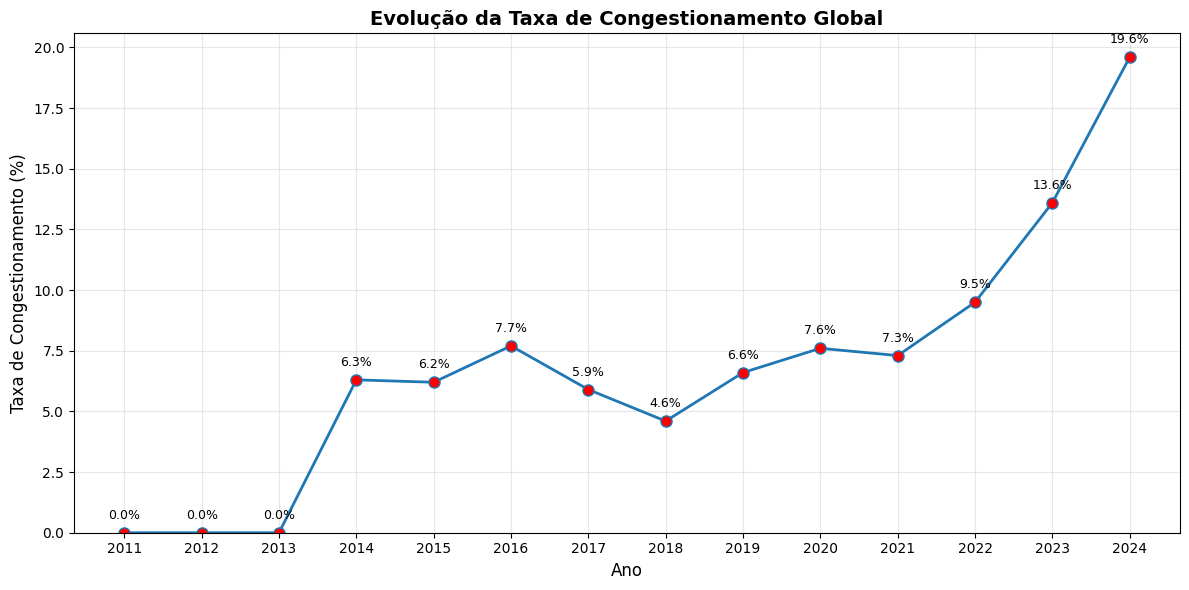


Tabela de Resultados:
Ano      Baixados     Pendentes    Taxa Cong. (%) 
------------------------------------------------------------
2011     4            0            0.00           
2012     2            0            0.00           
2013     2            0            0.00           
2014     197529       13385        6.30           
2015     229826       15164        6.20           
2016     257555       21485        7.70           
2017     394432       24573        5.90           
2018     565225       27510        4.60           
2019     567792       40313        6.60           
2020     554083       45573        7.60           
2021     806574       63231        7.30           
2022     892001       93104        9.50           
2023     953434       149923       13.60          
2024     1088630      265703       19.60          

Resumo do Processamento:
Total de arquivos CSV processados: 11
Período analisado: 2011 a 2024
Total de registros processados: 7267054


In [32]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import glob
import sys

# Listar os arquivos CSV na pasta 'uploads'
arquivo_csv = glob.glob('uploads/processos_*.csv')
# Carregar os arquivos CSV e concatenar em um único DataFrame
dfs = []
for arquivo in arquivo_csv:  # lista/iterável com os caminhos tipo 'processos_1.csv', 'processos_2.csv', ...
    df_ano = pd.read_csv(arquivo, sep=',', encoding='utf-8')
    dfs.append(df_ano)

df = pd.concat(dfs, ignore_index=True)

# Tratamento de colunas
colunas = df.columns.tolist()
def get_col(nome): return [c for c in colunas if nome in c.lower()][0]

df = df.rename(columns={
    get_col('data_distribuicao'): 'data_distribuicao',
    get_col('data_baixa'): 'data_baixa',
    get_col('nome_area_acao'): 'nome_area_acao',
    get_col('comarca'): 'comarca',
    get_col('serventia'): 'serventia'
})


df['data_distribuicao'] = pd.to_datetime(df['data_distribuicao'], errors='coerce')
df['data_baixa'] = pd.to_datetime(df['data_baixa'], errors='coerce')

# Extrair Anos
df['ano_distribuicao'] = df['data_distribuicao'].dt.year
df['ano_baixa'] = df['data_baixa'].dt.year

# Cálculo da taxa de congestionamento
# Agrupa apenas por ANO, somando tudo.
pendentes_total = df[df['data_baixa'].isna()].groupby('ano_distribuicao').size()
baixados_total = df.dropna(subset=['ano_baixa']).groupby('ano_baixa').size()

df_anual_unificado = pd.DataFrame({
    'Pendentes': pendentes_total,
    'Baixados': baixados_total
}).fillna(0).sort_index()

# Filtrar e Calcular
df_anual_unificado = df_anual_unificado[(df_anual_unificado['Pendentes'] > 0) | (df_anual_unificado['Baixados'] > 0)]
soma_total = df_anual_unificado['Pendentes'] + df_anual_unificado['Baixados']
df_anual_unificado['Taxa de Congestionamento (%)'] = np.where(
    soma_total > 0,
    (df_anual_unificado['Pendentes'] / soma_total) * 100,
    0
).round(1)
df_anual_unificado.index.name = 'Ano'
df_anual_unificado = df_anual_unificado.reset_index()
df_anual_unificado['Ano'] = df_anual_unificado['Ano'].astype(int)

# Criar o gráfico de linha
plt.figure(figsize=(12, 6))
plt.plot(df_anual_unificado['Ano'], df_anual_unificado['Taxa de Congestionamento (%)'], 
         marker='o', linewidth=2, markersize=8, markerfacecolor='red')

# Adicionar anotações com os valores
for i, row in df_anual_unificado.iterrows():
    plt.annotate(f"{row['Taxa de Congestionamento (%)']:.1f}%", 
                (row['Ano'], row['Taxa de Congestionamento (%)']),
                textcoords="offset points", 
                xytext=(0,10), 
                ha='center',
                fontsize=9)

# Configurações do gráfico
plt.title('Evolução da Taxa de Congestionamento Global', fontsize=14, fontweight='bold')
plt.xlabel('Ano', fontsize=12)
plt.ylabel('Taxa de Congestionamento (%)', fontsize=12)
plt.grid(True, alpha=0.3)
plt.xticks(df_anual_unificado['Ano'])  # Garantir que todos os anos sejam mostrados como inteiros

# Ajustar limites do eixo Y para melhor visualização
plt.ylim(bottom=0)

plt.tight_layout()
plt.show()

# Criar tabela com os resultados
tabela_resultados = df_anual_unificado.copy()

print("\nTabela de Resultados:")
print("=" * 60)
print(f"{'Ano':<8} {'Baixados':<12} {'Pendentes':<12} {'Taxa Cong. (%)':<15}")
print("-" * 60)
for _, row in tabela_resultados.iterrows():
    print(f"{int(row['Ano']):<8} {int(row['Baixados']):<12} {int(row['Pendentes']):<12} {row['Taxa de Congestionamento (%)']:<15.2f}")

# DataFrame formatado para uso posterior
df_tabela_final = tabela_resultados[['Ano', 'Baixados', 'Pendentes', 'Taxa de Congestionamento (%)']].copy()
df_tabela_final['Ano'] = df_tabela_final['Ano'].astype(int)
df_tabela_final['Baixados'] = df_tabela_final['Baixados'].astype(int)
df_tabela_final['Pendentes'] = df_tabela_final['Pendentes'].astype(int)

# Exibir informações sobre os dados processados
print(f"\nResumo do Processamento:")
print(f"Total de arquivos CSV processados: {len(arquivo_csv)}")
print(f"Período analisado: {df_tabela_final['Ano'].min()} a {df_tabela_final['Ano'].max()}")
print(f"Total de registros processados: {len(df)}")